In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data

In [2]:
# Compute funding rate PNL with only one market
exchanges_market = {
    "binance": "XRPUSDT",
    "bitmex": "XRPUSD",
    "apollox": "XRPUSDT",
    "drift": "XRP-PERP",
}
benchmark_exchange = "binance"

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchange, market in exchanges_market.items():
    data_df = pd.read_csv(f"./data/{exchange}_{market}.csv")
    data_df_map[exchange] = data_df

# calculate min max time
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    min_time = max(min_time, data_df["timestamp"].min())
    max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

    data_df = data_df[
        (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
    ]

    data_df = data_df.sort_values(by='datetime', ascending=True)
    data_df = data_df.reset_index(drop=True)

    result_df = get_backtest_result(data_df, leverage)
    results[exchange] = result_df

hodl_df = get_hodl_result(results[benchmark_exchange])

# Results are store in 'results' and 'hodl_df' variables

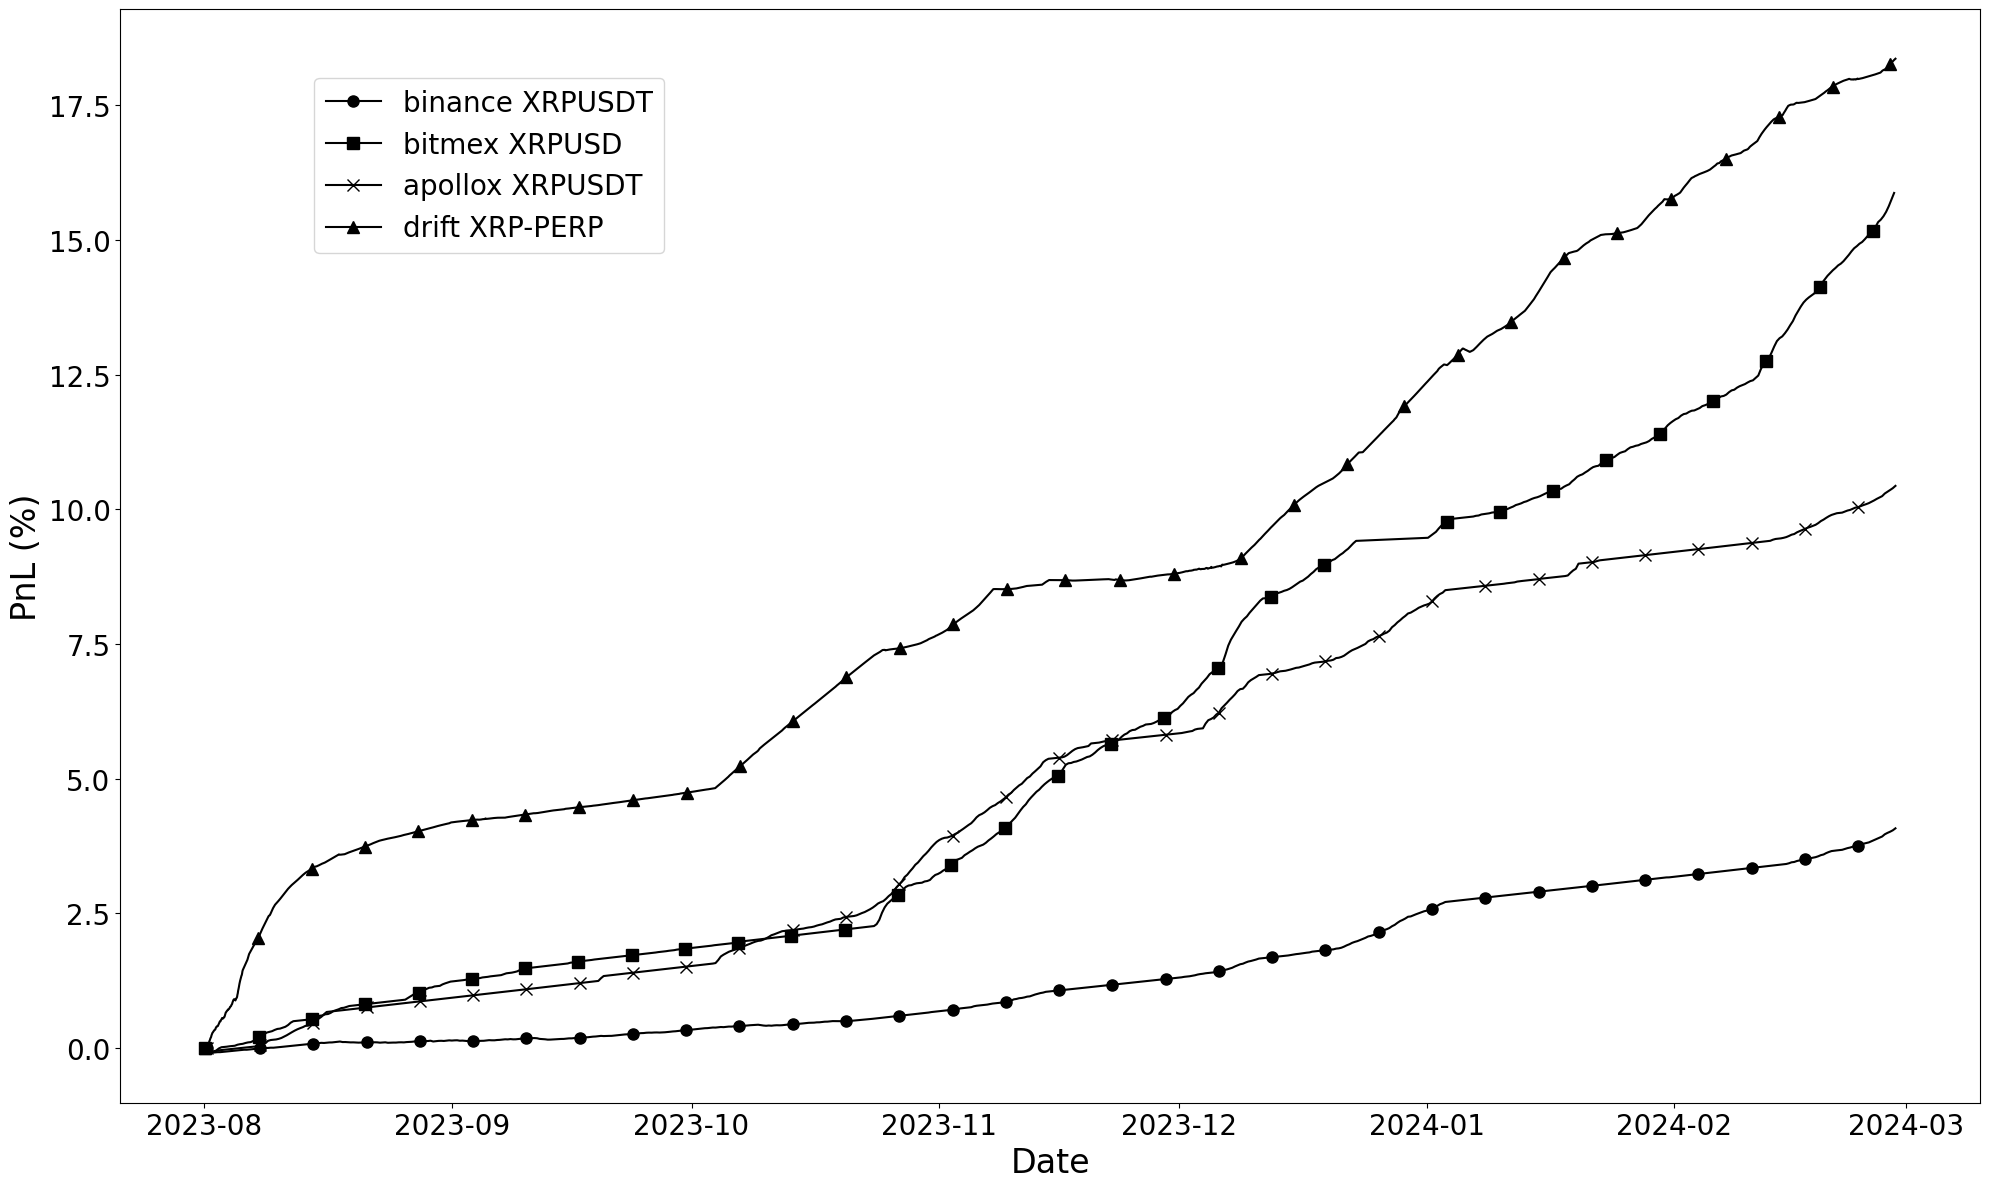

In [3]:
# Plot funding rate arb PNL only
markers = {"binance": "o", "bitmex": "s", "apollox": "x", "drift": "^"}
mark_every = {"binance": 20, "bitmex": 20, "apollox": 20, "drift": 160}

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    line,  = ax.plot(
        result_df["datetime"],
        result_df["final_pnl"] * 100,
        label=f"{exchange} {market}",
        color="black",
        ms=8,
        marker=markers[exchange],
        markevery=mark_every[exchange]
    )

# Chart settings
lines, labels = ax.get_legend_handles_labels()
plt.xlabel("Date", fontsize=24)
plt.ylabel("PnL (%)", fontsize=24)
ax.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.3, 0.95), fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig('./images/basic_funding_pnl.png', format='png', dpi=300, bbox_inches='tight')

plt.show()